# Check Error Template
Use this notebook to create a figure that shows error template creation and feature extraction. A lot of this code is just a cleaned up and combined version of the create error classifier notebook and the exploration_errp_template_detection notebook.

Nile Wilson 2019.04.08

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne

## Variables to Set

In [2]:
subjID = 'a1e6c0'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
session_number = 1

## Function Definitions

In [3]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

def LoadBehavioralData(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    behavioralHeader = behavioralData.columns
    behavioralData.head()
    
    return behavioralData

def SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        
        # Ignore the first error if the first movement was error
        # because the pulse value would be 0 and we wouldn't able to log that in index_trigger
        behavioral_error_trials = np.where(behavioralData['error_induced']==True)[0]

        # Only store info for trials that are confirmed to be error movement from both the EEG data and from the behavioral data
        # Start from 1 and not 0 because 0 is used for no pulse sent as well
        error_trials = np.intersect1d(np.unique(EEGdata['STI 014'])[1:], behavioral_error_trials)
        
        index_trigger = list()
        for i in range(0,len(error_trials)):
            index_trigger.append(np.where(EEGdata['STI 014'] == error_trials[i])[0][-1])
        
        # Check number of trials
        num_of_trials = behavioralData.shape[0]
        num_of_error = len(index_trigger)
        num_of_correct = num_of_trials - num_of_error - 1 # skipped the initial error movement because it had pulseValue 0
        
        # Get the movement start times
        t_diff_all = list()
        for i in range(0, len(index_trigger)):
            t_diff_all.append((index_trigger[i]/fs)-behavioralData['time'][error_trials[i]])
        
        # Add t_0 to find the times in the EEG data
        t_0 = np.mean(t_diff_all)
        t_trial_start = list()
        for i in range(0, num_of_trials):
            t_trial_start.append(behavioralData['time'][i] + t_0)
            
        # Get a nice list of whether a trial is error or not
        isError = list()
        error_trials = list()
        correct_trials = list()
        for i in range(0, len(behavioralData['error_induced'])):
            if behavioralData['error_induced'][i] == True:
                isError.append(1)
                error_trials.append(i)
            else:
                isError.append(0)
                correct_trials.append(i)

        correct_trials = np.asarray(correct_trials)

    
    return num_of_trials, t_trial_start, error_trials, correct_trials, isError

def EpochData(EEGdata, t_trial_start):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]
    
    epochs_norm = []

    for trial in range(0,len(t_trial_start)):
        t_start = np.round((t_trial_start[trial] - 0 ) * fs)
        t_end = np.round((t_trial_start[trial] + 0.600) * fs)

        # Baseline
        tb_start = np.round((t_trial_start[trial] - 0.700 ) * fs)
        tb_end = np.round((t_trial_start[trial] - 0.100) * fs)
        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline,0))/np.std(baseline,0)
        epochs_norm.append(tmp)
    
    return epochs_norm

def GenerateTemplates(epochs_norm, error_trials, correct_trials):
    """
    Generate grand average waveform templates for both error and correct responses for all channels
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]
        
    # Get average timeseries waveform for error and correct
    channelsOfInt = channels
    error_template = dict()
    correct_template = dict()

    for chanOfInt in channelsOfInt:
        tmp_to_avg_error = list()
        tmp_to_avg_correct = list()

        for trial in error_trials:
            tmp = epochs_norm[trial][chanOfInt].values
            tmp_to_avg_error.append(tmp)

        for trial in correct_trials:
            tmp = epochs_norm[trial][chanOfInt].values
            tmp_to_avg_correct.append(tmp)

        # Plot the average in bold black
        error_template[chanOfInt] = np.mean(tmp_to_avg_error,0)
        correct_template[chanOfInt] = np.mean(tmp_to_avg_correct,0)
    
    return error_template, correct_template

def ExtractFeatures(epochs, num_of_trials, error_template, correct_template, featureType):
    """
    Extract signal features of interest
    featureType:    'template' or 'frequency'. 'template' returns features based on the template projection values
                    for individual epochs with the error and correct templates. 'frequency' returns features that
                    are just delta and theta power for each channel for the epochs
    """
    
    if featureType in ['template','Template','TEMPLATE','t','T','projection','Projection','PROJECTION','p','P']:
        # template_projection[chanOfInt] will have two columns
        # col 1: how well the trial signal matches with the error signal template
        # col 2: how well the trial signal matches with the correct signal template
        projections_all = dict()
        channelsToUse = error_template.keys()

        for chanOfInt in channelsToUse:
            projections = np.zeros([2, num_of_trials])
            for trial in range(0, num_of_trials):
                # Individual epoch (normalized)
                tmp = epochs_norm[trial][chanOfInt]
                a = tmp

                # Template waveform for error (normalized)
                tmp0 = error_template[chanOfInt]
                tmp_norm = (tmp0 - np.mean(tmp0))/np.std(tmp0)
                b = tmp_norm

                # Template waveform for correct (normalized)
                tmp = correct_template[chanOfInt]
                tmp_norm = (tmp - np.mean(tmp0))/np.std(tmp0)
                c = tmp_norm

                # Store sum of convolutions

                projections[0][trial] = np.sum(np.convolve(a,b,'same'))
                projections[1][trial] = np.sum(np.convolve(a,c,'same'))

            projections_all[chanOfInt] = projections
        
        # Organize the features
        channels = list(projections_all.keys())
        num_of_features = np.shape(projections_all['Cz'])[0] * len(channels)
        channels_full = list(projections_all.keys()) * 2
        num_of_trials = np.shape(projections_all['Cz'])[1]

        features = np.zeros([num_of_features, num_of_trials])

        for trial in range(0, num_of_trials):
            # Error trials are 0 to num_of_features//2, and correct trials are num_of_features//2 to num_of_features
            for feature in range(0, num_of_features):
                features[feature, trial] = projections_all[channels_full[feature]][0][trial]
            
    elif featureType in ['frequency','Frequency','FREQUENCY','f','F']:
        channelsToUse = error_template.keys()
        delta_power = dict.fromkeys(channelsToUse)
        theta_power = dict.fromkeys(channelsToUse)
        ds_f = 1 # downsampling factor

        for chanOfInt in channelsToUse:
            tmp_delta = list()
            tmp_theta = list()

            for trial in range(0, num_of_trials):
                f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
                delta_idx = np.where(np.round(f) <= 4)
                tmp_delta.append(np.sum(Pxx_den[delta_idx]))

                theta_idx = np.where(np.logical_and(np.round(f) > 4, np.round(f) <= 7))
                tmp_theta.append(np.sum(Pxx_den[theta_idx]))

            delta_power[chanOfInt] = tmp_delta
            theta_power[chanOfInt] = tmp_theta
            
        # Organize the features
        num_of_examples = len(delta_power['Cz'])
        num_of_features = len(delta_power.keys()) + len(theta_power.keys()) 
        features = np.zeros([num_of_features, num_of_examples])

        # Get all channels in one list to loop through
        feature_channels = np.concatenate([np.asarray(list(delta_power.keys())),np.asarray(list(theta_power.keys()))])

        for i in range(0, num_of_examples):
            for j in range(0, num_of_features//2):
                features[j, i] = delta_power[feature_channels[j]][i]
            for j in range(num_of_features//2, num_of_features):
                features[j, i] = theta_power[feature_channels[j]][i]

    
    return features

## Code to Run

In [4]:
eeg_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*_' + subjID + '_Error*.easy')
filename_eeg = eeg_files[-1] # load the most recent eeg file
print(filename_eeg)

behav_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/Error_Screening_' + subjID + '*.csv')
filename_behavioral = behav_files[-1] # load the most recent behavioral file
print(filename_behavioral)

SaveData/a1e6c0/Session1\20190319131405_a1e6c0_Error_Screening.easy
SaveData/a1e6c0/Session1\Error_Screening_a1e6c0_R1.csv


### Load and clean

In [5]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralData(filename_behavioral)

# Sync up trigger pulses
num_of_trials, t_trial_start, error_trials, correct_trials, isError = SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData)

# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:8]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

# Make a copy of the original data just in case
EEGdata[channels] = raw.get_data().T

Skipping N/A
Creating RawArray with float64 data, n_channels=8, n_times=326648
    Range : 0 ... 326647 =      0.000 ...   653.294 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


### Epoch data, get features, train!

In [6]:
# Epoch the data
epochs_norm = EpochData(EEGdata, t_trial_start)

# Generate error and correct waveform templates
error_template, correct_template = GenerateTemplates(epochs_norm, error_trials, correct_trials)

# Get features
featureType = 'frequency'
features = ExtractFeatures(epochs_norm, num_of_trials, error_template, correct_template, featureType)

C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


## Plot

In [55]:
movementOfInt = 50
chanOfInt_plot = 'Cz'

Let's go ahead and get the projections for this by template

In [56]:
x = np.asarray(epochs_norm[movementOfInt][chanOfInt_plot])
t_plot = np.linspace(0, len(x)/fs, len(x))

# template_projection[chanOfInt] will have two columns
# col 1: how well the trial signal matches with the error signal template
# col 2: how well the trial signal matches with the correct signal template
projections_all = dict()
channelsToUse = error_template.keys()

for chanOfInt in channelsToUse:
    projections = np.zeros([2, num_of_trials])
    for trial in range(0, num_of_trials):
        # Individual epoch (normalized)
        tmp = epochs_norm[trial][chanOfInt]
        a = tmp

        # Template waveform for error (normalized)
        tmp0 = error_template[chanOfInt]
        tmp_norm = (tmp0 - np.mean(tmp0))/np.std(tmp0)
        b = tmp_norm

        # Template waveform for correct (normalized)
        tmp = correct_template[chanOfInt]
        tmp_norm = (tmp - np.mean(tmp0))/np.std(tmp0)
        c = tmp_norm

        # Store sum of convolutions

        projections[0][trial] = np.sum(np.convolve(a,b,'same'))
        projections[1][trial] = np.sum(np.convolve(a,c,'same'))

    projections_all[chanOfInt] = projections

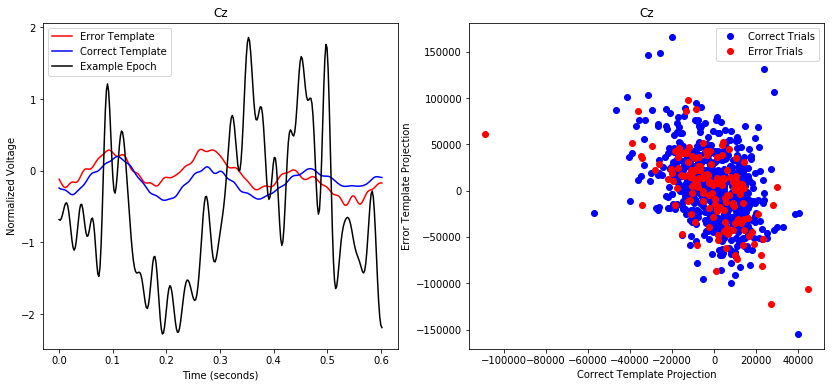

movement #: 50
subjID: a1e6c0


In [57]:
plt.figure(figsize=(14,6))
chanOfInt = chanOfInt_plot

# Plot waveform example
plt.subplot(121)
plt.plot(t_plot, error_template[chanOfInt], 'r')
plt.plot(t_plot, correct_template[chanOfInt], 'b')
plt.plot(t_plot, np.asarray(epochs_norm[movementOfInt][chanOfInt]), 'k')
plt.legend(['Error Template','Correct Template','Example Epoch'])
plt.ylabel('Normalized Voltage')
plt.xlabel('Time (seconds)')
plt.title(chanOfInt)

# Plot scatter plot
plt.subplot(122)
tmp = projections_all[chanOfInt]
plt.plot(tmp[0][correct_trials], tmp[1][correct_trials], 'bo')
plt.plot(tmp[0][error_trials], tmp[1][error_trials], 'ro')

plt.title(chanOfInt)
plt.xlabel('Correct Template Projection')
plt.ylabel('Error Template Projection')
plt.legend(['Correct Trials','Error Trials'])

plt.show()

print('movement #: ' + str(movementOfInt))
print('subjID: ' + subjID)